In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz
from mpmath import mp, invertlaplace, mpc, mpf, sqrt, exp, pi, erfc
import scipy
from tqdm import tqdm
from scipy.integrate import simpson
import math

x_0_sampled = True

_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.290153649828586e-06
_gain = np.sqrt(450696654238001.6)
_K = 6.746007702007992e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_eta = 0.32e-3
_gamma = 6 * np.pi * _r * _eta
z = 6*_r**2*np.sqrt(np.pi * _eta * _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((_k_b*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, _m, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return _m*x0*a_inverse_form(t, roots) + _m*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

# THIS FUNCTION ASSUMES ZERO INITIAL VELOCITY
def v_t1_v_t2_zero_v0(t1, t2, m, K):
    return _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))

# This is the deterministic part of VACF with given v_0
def h_and_i(t, _m, v0, roots):
    return _m*v0*a_inverse_form(t, roots) #CANCELS + z*v0*s_half_b_inverse_form(t, roots)

#This function takes in v_0 - More general
def v_t1_v_t2(t1, t2, m, K, v0):
    return h_and_i(t1, m, v0, roots)*h_and_i(t2, m, v0, roots) + _k_b*_temp*(a_inverse_form(np.abs(t2-t1), roots) - m*a_inverse_form(t1, roots)*a_inverse_form(t2, roots) - K*b_inverse_form(t1, roots)*b_inverse_form(t2, roots))


def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)


# History term in Laplace domain - see overleaf doc
def F(s, tau):
    s = mpc(s)
    tau = mpf(tau)
    D = _m*(roots[0] + sqrt(s)) * (roots[1] + sqrt(s)) * (roots[2] + sqrt(s)) * (roots[3] + sqrt(s))
    inv = 1/sqrt(-tau) - 1 * exp(-tau*s) * sqrt(s) * sqrt(pi) * erfc(sqrt(-tau*s))
    return inv / D

# Inverse Laplace transform F^-1[f(s, tau)] -> f(t, tau)
def f(t, tau):
    def F_fixed_s(s):
        return F(s, tau) # Calls the actual function
    return float(mp.re(invertlaplace(F_fixed_s, t, method='talbot')))


def cross_correlation(series1, series2, dt):
    if(len(series1) != len(series2)):
        print("series1 has " + str(len(series1)))
        print("series2 has " + str(len(series2)))
        return 0
    n = len(series1)
    cc = np.zeros(n)  # Allocate array for MSD
    lag_times = np.arange(1, n, 1) * dt  # Calculate lag times

    for tau in tqdm(np.array(range(1, n, 1))):
        cc_tau = series1[tau:]*series2[:n - tau]
        cc[tau] = np.mean(cc_tau)
    cc[0] = 0
    return cc, lag_times


def get_basset_force(a_series, start_idx):
    max_tau = start_idx
    lags = np.arange(1, max_tau+1)[::-1]/fs_sim
    basset_integral = []
    for curr_idx in tqdm(range(start_idx, len(a_series))):
        curr_integral = simpson(a_series[curr_idx-max_tau:curr_idx]/np.sqrt(lags), x=lags[::-1])
        basset_integral.append(curr_integral)
    return basset_integral


def bin_data(series, bin_size):
    # Ensuring the length of series is divisible by bin_size
    length = len(series) - len(series) % bin_size
    series = np.array(series[:length])
    return np.mean(series.reshape(-1, bin_size), axis=1)

def get_acceleration(velocity, dt):
    acceleration = np.zeros_like(velocity)

    # Use forward difference at the first point
    acceleration[0] = (velocity[1] - velocity[0]) / dt

    # Use centered difference for the middle points
    acceleration[1:-1] = (velocity[2:] - velocity[:-2]) / (2 * dt)

    # Use backward difference at the last point
    acceleration[-1] = (velocity[-1] - velocity[-2]) / dt

    return acceleration

In [2]:
# High precision for inverse Laplace
mp.dps = 30

# Time grid (log-spaced in negative time)
tau_min = 1e-12
tau_max = 1e-1

# Number of tau points
N = 100

# Number of time (forward points)
points = 101

Set v_0

In [3]:
v_nots = [0 * np.sqrt(_k_b * _temp / _m),.5 * np.sqrt(_k_b * _temp / _m), 1 * np.sqrt(_k_b * _temp / _m), 2 * np.sqrt(_k_b * _temp / _m)]
speeds = [0, .5, 1, 2]

In [4]:
t_evals = 0
term1s = []
term2s = []
analytics = []
analytics_interp = []

In [5]:
print("hi")

hi


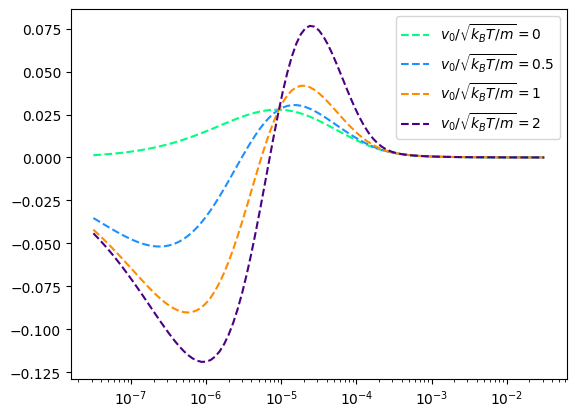

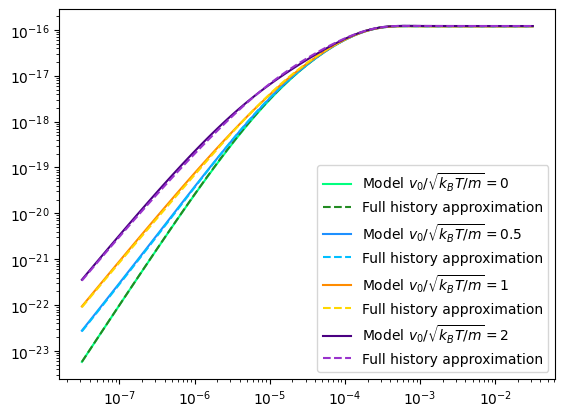

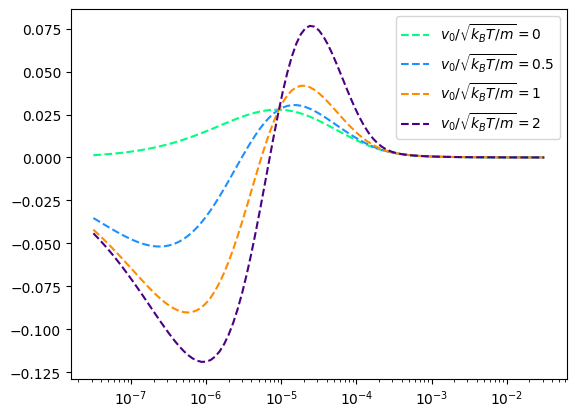

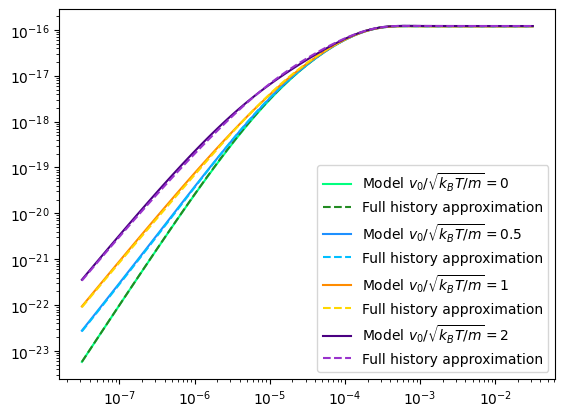

In [9]:
import matplotlib.colors as mcolors
colors = [['springgreen', 'forestgreen'],
          ['dodgerblue', 'deepskyblue'],
          ['darkorange', 'gold'],
          ['indigo', 'darkorchid']]
for idx in range(len(term1s)):
    plt.plot(t_evals, np.array(term1s[idx]+term2s[idx])/analytics_interp[idx], linestyle='dashed', label=r"$v_0/\sqrt{k_B T/m}=$"+f"{speeds[idx]}", color=mcolors.CSS4_COLORS[colors[idx][0]])
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

for idx in range(len(term1s)):
    plt.plot(t_evals, np.array(analytics_interp[idx]), label=r"Model $v_0/\sqrt{k_B T/m}=$"+f"{speeds[idx]}", color=mcolors.CSS4_COLORS[colors[idx][0]])
    plt.plot(t_evals, np.array(term1s[idx]+term2s[idx]+analytics_interp[idx]), linestyle='dashed', label=r"Full history approximation", color=mcolors.CSS4_COLORS[colors[idx][1]])
plt.xscale('log')
plt.yscale('log')
# plt.xlim(left=1e-6, right=2e-6)
plt.legend()
plt.show()

# Save t_evals, term1s, term2s, analytics_interp into text file
import pickle

with open("model_data.pkl", "wb") as f:
    pickle.dump({
        "t_evals": t_evals,
        "term1s": term1s,
        "term2s": term2s,
        "analytics_interp": analytics_interp,
        "speeds": speeds
    }, f)
import pickle

with open("model_data.pkl", "rb") as f:
    data = pickle.load(f)

t_evals2 = data["t_evals"]
term1s2 = data["term1s"]
term2s2 = data["term2s"]
analytics_interp2 = data["analytics_interp"]
speeds2 = data["speeds"]

for idx in range(len(term1s)):
    plt.plot(t_evals2, np.array(term1s2[idx]+term2s2[idx])/analytics_interp2[idx], linestyle='dashed', label=r"$v_0/\sqrt{k_B T/m}=$"+f"{speeds2[idx]}", color=mcolors.CSS4_COLORS[colors[idx][0]])
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()

for idx in range(len(term1s)):
    plt.plot(t_evals, np.array(analytics_interp2[idx]), label=r"Model $v_0/\sqrt{k_B T/m}=$"+f"{speeds2[idx]}", color=mcolors.CSS4_COLORS[colors[idx][0]])
    plt.plot(t_evals, np.array(term1s2[idx]+term2s2[idx]+analytics_interp2[idx]), linestyle='dashed', label=r"Full history approximation", color=mcolors.CSS4_COLORS[colors[idx][1]])
plt.xscale('log')
plt.yscale('log')
# plt.xlim(left=1e-6, right=2e-6)
plt.legend()
plt.show()


100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


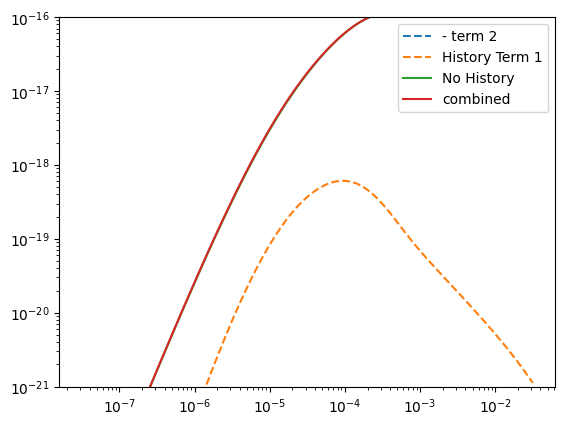

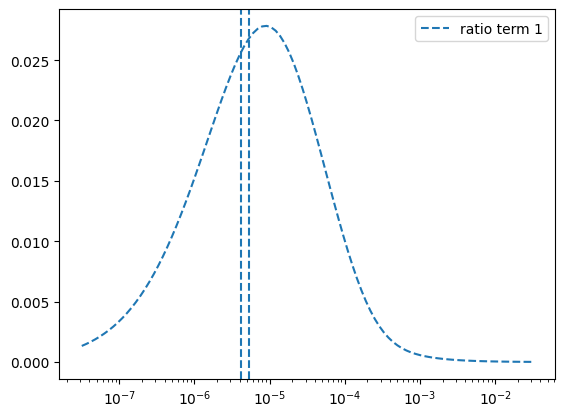

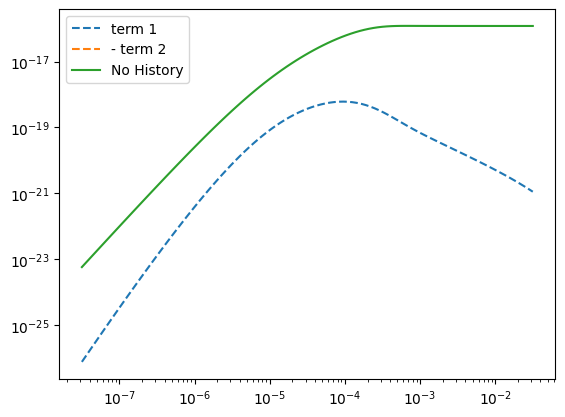

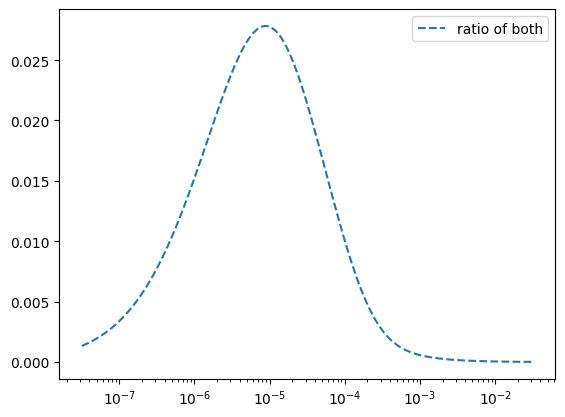

100%|██████████| 100/100 [03:58<00:00,  2.39s/it]


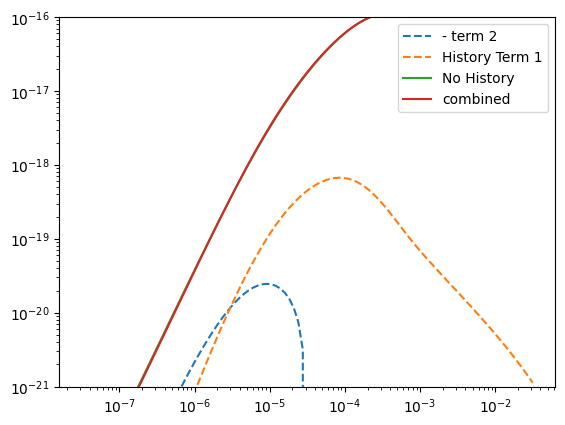

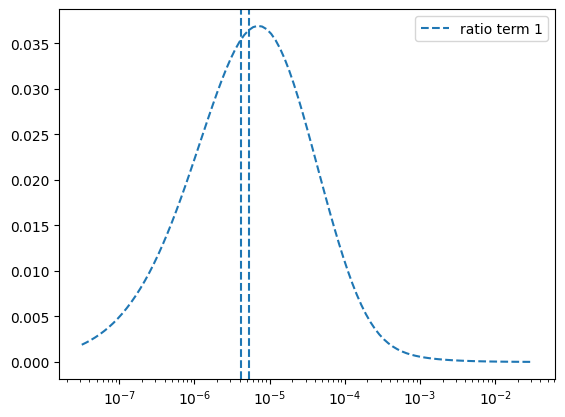

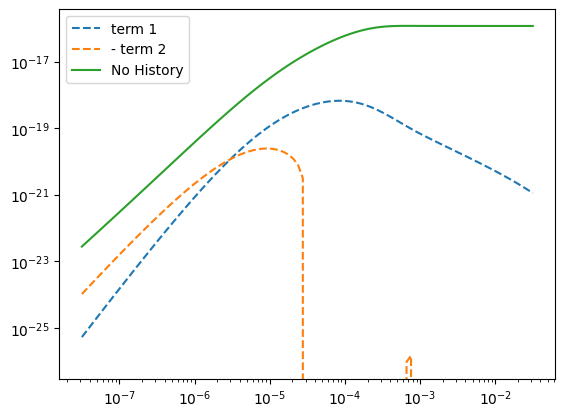

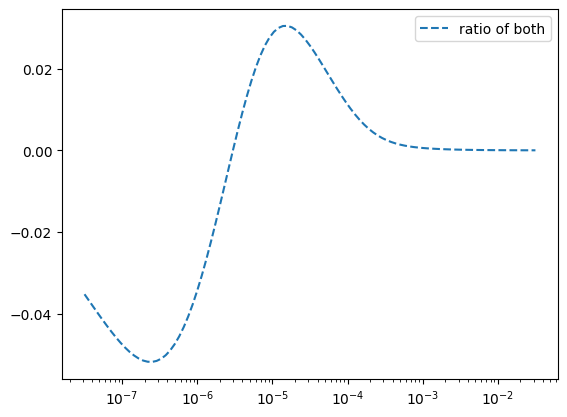

100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


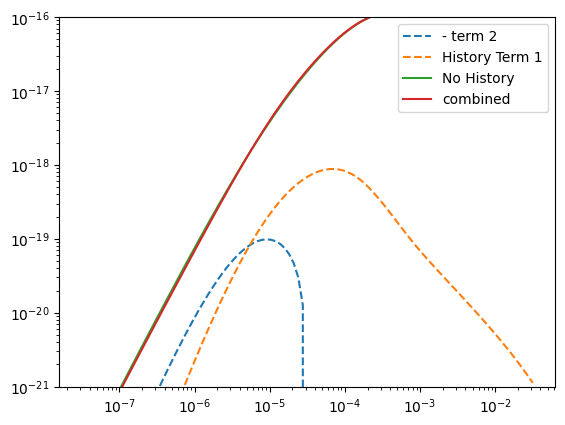

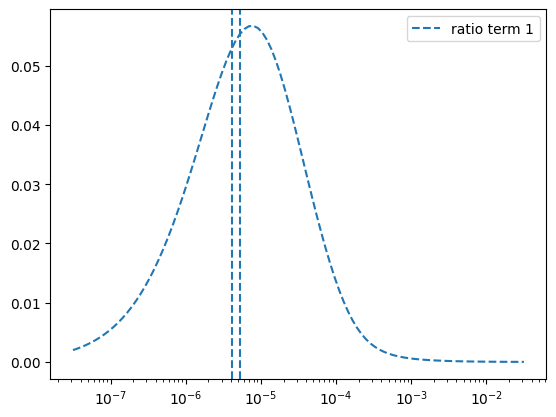

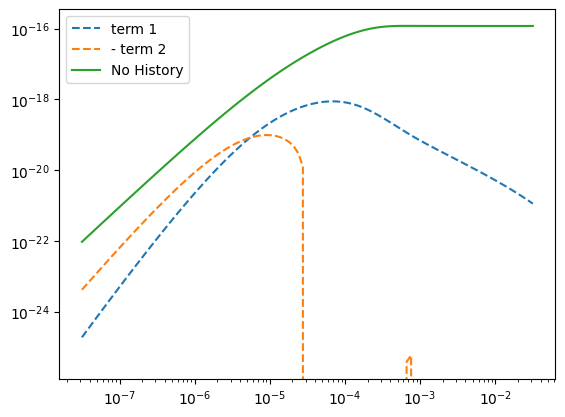

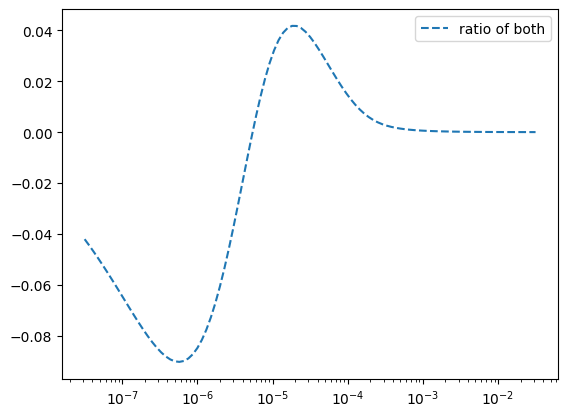

100%|██████████| 100/100 [03:54<00:00,  2.34s/it]


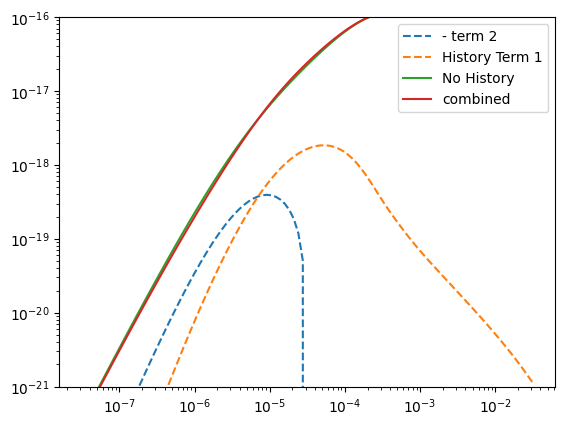

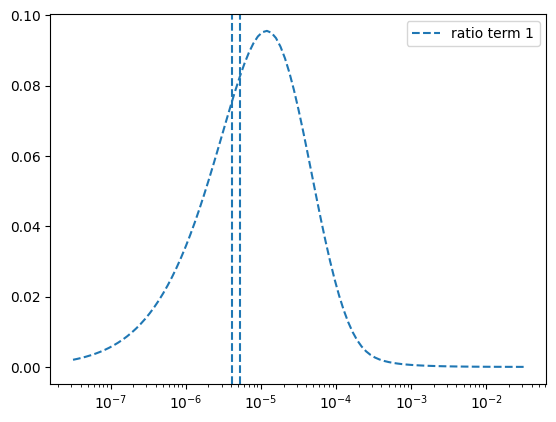

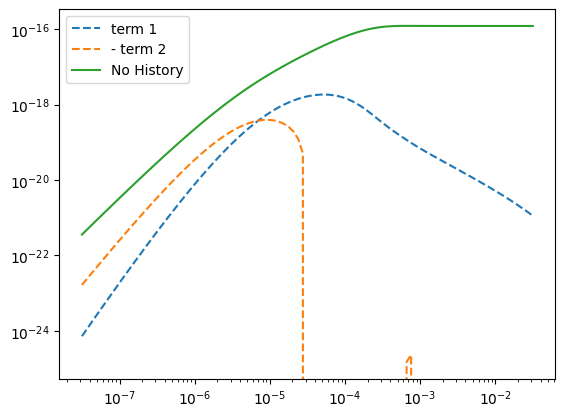

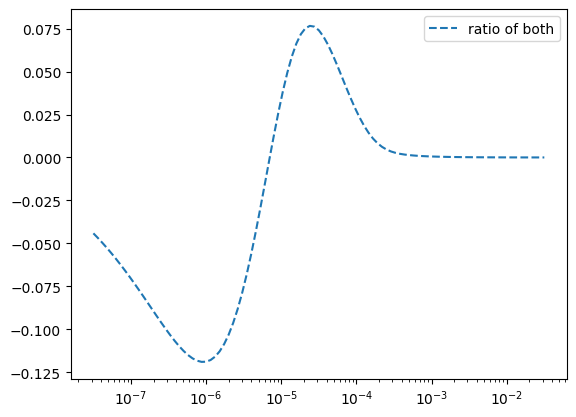

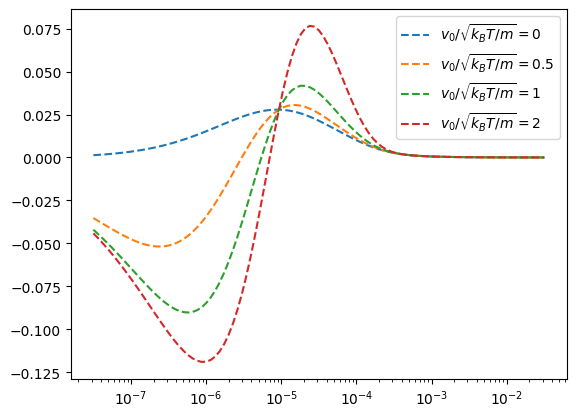

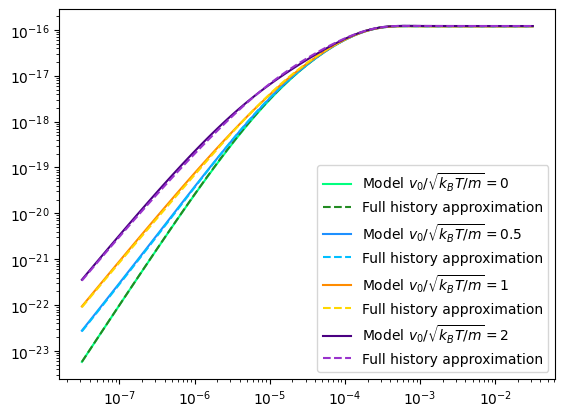

In [6]:
for v_not in v_nots:    
    times_analytic = np.logspace(-7.5, -1.5, 100)
    roots = compute_roots(_m, _K, _r, _eta, _rho_f)
    
    mu = 0
    # sigma_v = np.sqrt(_k_b*_temp/_m)
    sigma_x = np.sqrt(_k_b*_temp/_K)
    num_samples = 10000
    
    
    # initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
    initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
    speeds_analytic = 0
    
    if x_0_sampled:
        for i in range(num_samples):
            results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, initial_conditions_x[i], v_not)
        speeds_analytic=results_speed_no_half.mean(axis=0)
    else:
        speeds_analytic = full_hydro_msd(0, times_analytic, _m, _K, _r, _eta, _rho_f, 0, v_not)
    
    analytics.append(speeds_analytic)
    tau_array = -np.logspace(np.log10(tau_min), np.log10(tau_max), N)[::-1] # Backwards logspace
    
    t_evals = np.logspace(-7.5, -1.5, points)
    msd_hs = []
    count = 0
    
    for t_eval in tqdm(t_evals):
        count +=1
        # Compute f(t, tau) for all tau
        f_vals = []
        for tau in tau_array:
            f_vals.append(f(t_eval, tau)) # tau is backwards time, t_eval is forwards
        fvals = np.array(f_vals)
        # Build the 2D integrand: VACF(tau1, tau2) * f(t, tau1) * f(t, tau2)
        T1, T2 = np.meshgrid(tau_array, tau_array, indexing='ij')
        f1 = fvals[:, np.newaxis]
        f2 = fvals[np.newaxis, :]
        VACF_grid = v_t1_v_t2(-1*T1, -1*T2, _m, _K, v_not) # This function is the VACF from the Clerx and Schram paper (before they take the stationary part) so it inherently assumes no history ... It does give us the aproximate strength of the VACF given the lag time between T1 and T2...
        integrand = VACF_grid * f1 * f2 # Here we construct the full integrand in matrix form. It corresponds to the second term in equation 36 from the history write up... The third/fourth term are due to random force/velocity correlation...
        # Integrate over tau1 and tau2
        msd_history = simpson(simpson(integrand, tau_array, axis=1), tau_array)
        # print(f"MSD_history(t = {t_eval:.2e}) = {msd_history:.5e}")
        msd_hs.append(msd_history*z**2)
        
    inv_term2 = []
    for tau in tqdm(tau_array):
        inv_term2.append([f(t, tau) for t in t_evals])
    
    integrand = np.array(inv_term2)*_m*v_not**2*a_inverse_form(t_evals,roots)
    #calcluate integral wrt tau to get out something as a func of t_evals
    integral = simpson(integrand, tau_array, axis = 0)
    #multiply by prefactor to get term2 result
    term2 = -integral*_m*_gamma*_r*np.sqrt(_rho_f/(_eta*np.pi))*b_inverse_form(t_evals,roots) # this is the second b inverse form that technically has difference time
    
    plt.plot(t_evals, -term2, linestyle='dashed', label="- term 2")
    plt.plot(t_evals, msd_hs, linestyle='dashed', label="History Term 1")
    plt.plot(times_analytic, speeds_analytic, label = r"No History")
    
    tau_p_for_plot = _m/_gamma#3*np.pi*_r**2*_rho_f/_eta
    tau_f_for_plot = _r**2*_rho_f/_eta
    from scipy.interpolate import interp1d
    
    intrp = interp1d(times_analytic, speeds_analytic)
    analytic = intrp(t_evals)
    analytics_interp.append(analytic)
    plt.plot(t_evals, msd_hs+analytic+term2, label = 'combined')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.ylim(bottom=1e-21, top=1e-16)
    plt.show()
    
    plt.plot(t_evals, np.array(msd_hs)/np.array(analytic), linestyle='dashed', label="ratio term 1")
    plt.axvline(tau_p_for_plot, linestyle='dashed')
    plt.axvline(tau_f_for_plot, linestyle='dashed')
    plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()
    
    
    plt.plot(t_evals, msd_hs, linestyle='dashed', label="term 1")
    plt.plot(t_evals, -term2, linestyle='dashed', label="- term 2")
    plt.plot(times_analytic, speeds_analytic, label = r"No History")
    plt.plot()
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    plt.plot(t_evals, np.array(msd_hs+term2)/np.array(analytic), linestyle='dashed', label="ratio of both")
    plt.plot()
    plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    plt.show()
    
    term1s.append(msd_hs)
    term2s.append(term2)
    
import matplotlib.colors as mcolors
for idx in range(len(term1s)):
    plt.plot(t_evals, np.array(term1s[idx]+term2s[idx])/analytics_interp[idx], linestyle='dashed', label=r"$v_0/\sqrt{k_B T/m}=$"+f"{speeds[idx]}")
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.show()
colors = [['springgreen', 'forestgreen'],
          ['dodgerblue', 'deepskyblue'],
          ['darkorange', 'gold'],
          ['indigo', 'darkorchid']]
for idx in range(len(term1s)):
    plt.plot(t_evals, np.array(analytics_interp[idx]), label=r"Model $v_0/\sqrt{k_B T/m}=$"+f"{speeds[idx]}", color=mcolors.CSS4_COLORS[colors[idx][0]])
    plt.plot(t_evals, np.array(term1s[idx]+term2s[idx]+analytics_interp[idx]), linestyle='dashed', label=r"Full history approximation", color=mcolors.CSS4_COLORS[colors[idx][1]])
plt.xscale('log')
plt.yscale('log')
# plt.xlim(left=1e-6, right=2e-6)
plt.legend()
plt.show()